<br> 
‚Äã
<div class="alert alert-info"><b>PROJET 10 : DETECTER DES FAUX BILLETS</b> 
‚Äã


<br> 

<div class="alert alert-warning"><b>CONTEXTE</b> 
    
    
L'Organisation nationale de lutte contre le faux-monnayge(ONCFM) a pour objectif de mettre en place des m√©thodes d'identification des contrefa√ßons des billets en euros.
    
<b>Objectif</b>: 
    
Mettre en place une mod√©lisation qui serait capable d'identifier automatiquement les vrais des faux billets. Et ce √† partir de certaines dimensions du billet et des √©l√©ments qui le composent. 
    

# IMPORTER LES LIBRAIRIES ET LES DONNEES

In [1]:
import os
import warnings

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

from statsmodels.formula.api import ols
from statsmodels.compat import lzip
from statsmodels.stats.outliers_influence import variance_inflation_factor

from scipy.stats import chi2_contingency,t, shapiro
import scipy.stats as st
from scipy.stats import norm

from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, SGDRegressor
from sklearn import metrics

import warnings
warnings.filterwarnings("ignore")

In [2]:
billet = pd.read_csv(r'C:\Users\BDS CREATIONS\OneDrive\Bureau\OPEN CLASS ROOM\PROJETS OCR\PROJET 10\billets.csv', sep=';')

In [3]:
billet_all = pd.read_csv(r'C:\Users\BDS CREATIONS\OneDrive\Bureau\OPEN CLASS ROOM\PROJETS OCR\PROJET 10\billets.csv', sep=';')
billet_2 = pd.read_csv(r'C:\Users\BDS CREATIONS\OneDrive\Bureau\OPEN CLASS ROOM\PROJETS OCR\PROJET 10\billets.csv', sep=';')

# Pr√©paration des donn√©es

## Exploration des donn√©es

In [4]:
# 5 premi√®res lignes -
billet.head()

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0        True    171.81       104.86        104.95        4.52       2.89   
1        True    171.46       103.36        103.66        3.77       2.99   
2        True    172.69       104.48        103.50        4.40       2.94   
3        True    171.36       103.91        103.94        3.62       3.01   
4        True    171.73       104.28        103.46        4.04       3.48   

   length  
0  112.83  
1  113.09  
2  113.16  
3  113.51  
4  112.54

In [5]:
# 5 derni√®res lignes
billet.tail()

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
1495       False    171.75       104.38        104.17        4.42       3.09   
1496       False    172.19       104.63        104.44        5.27       3.37   
1497       False    171.80       104.01        104.12        5.51       3.36   
1498       False    172.06       104.28        104.06        5.17       3.46   
1499       False    171.47       104.15        103.82        4.63       3.37   

      length  
1495  111.28  
1496  110.97  
1497  111.95  
1498  112.25  
1499  112.07

In [6]:
# 5 lignes dans le jeu de donn√©es
billet.sample(5)

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
698         True    172.24       103.97        104.11        4.02       2.84   
848         True    172.44       104.26        103.56        3.48       3.12   
485         True    171.83       104.29        103.58        4.00       3.32   
274         True    171.52       103.74        104.10        4.47       2.87   
1298       False    172.00       104.36        104.16        4.94       3.25   

      length  
698   113.15  
848   112.70  
485   113.21  
274   113.58  
1298  111.82

In [7]:
# Informations globales sur le jeu de donn√©es
billet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


In [8]:
# taille du jeu de donn√©es
billet.shape

(1500, 7)

In [9]:
# nombre de variables par colonne
billet.count()

is_genuine      1500
diagonal        1500
height_left     1500
height_right    1500
margin_low      1463
margin_up       1500
length          1500
dtype: int64

In [10]:
# liste des colonnes
list(billet)

['is_genuine',
 'diagonal',
 'height_left',
 'height_right',
 'margin_low',
 'margin_up',
 'length']

In [11]:
# NaNs dans le jeu de donn√©es
billet.isnull().sum()

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

<br>
<div class="alert alert-success">
<b>NOTE</b> 

Le fichier comporte 1500 donn√©es et 7 colonnes.

6 colonnes concernent les caract√©ristiques des billets et une colonne nous indique si le billet est vrai ou faux. 
    
Nous constatons 37 valeurs manquantes dans la colonne margin_low.

In [12]:
# cr√©ation d'un df avec les donn√©es manquantes
df_nan = billet[billet.isnull().any(axis=1)]

# cr√©ation d'un df sans les donn√©es manquantes
billet = billet.dropna(how='any')

# Visualisation des donn√©es

> Avant de traiter nos valeurs manquantes il est judicieux de visualiser nos donn√©es pour mieux les comprendre et voir s‚Äôil existe une relation entre chaque variable.

## Repr√©sentation des effectifs par type de billets

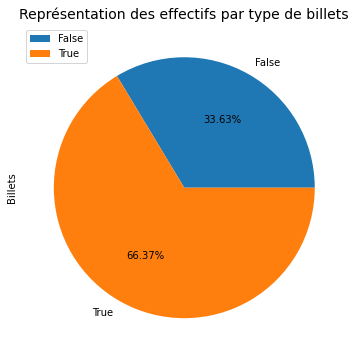

In [13]:
t = pd.crosstab(billet.is_genuine, "Billets")
t.plot.pie(subplots=True, figsize = (6, 6), autopct = lambda billet: str(round(billet,2)) + '%' )
plt.title('Repr√©sentation des effectifs par type de billets', fontsize = 14);

- 66.37% des billets sont vrais dans notre jeu de donn√©es.
- 33.63% des billets sont faux dans notre jeu de donn√©es.

## Repr√©sentation de la distribution des variables par rapport √† la variable 'is_genuine'

In [14]:
billet_faux = billet[billet['is_genuine'] == False]

billet_vrai = billet[billet['is_genuine'] == True]

R√©partition des donn√©es


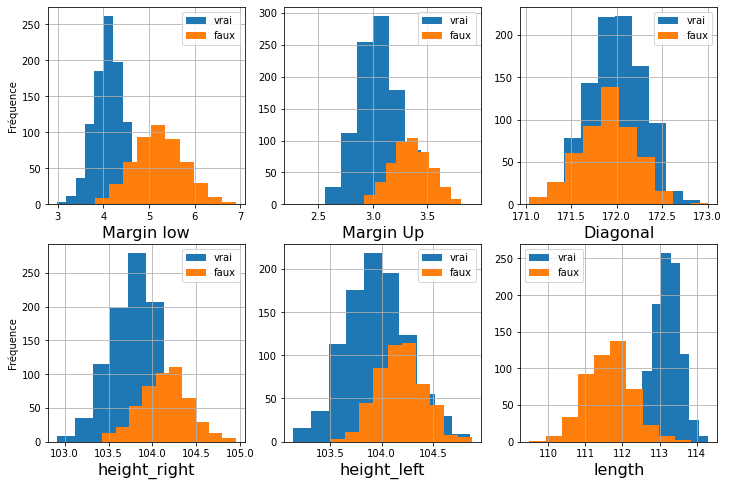

In [15]:
plt.rcParams["figure.figsize"] = [12,8]
print('R√©partition des donn√©es')


labels = ['vrai', 'faux']

plt.subplot(2,3,1)
billet_vrai.margin_low.hist(label = 'vrais billets')
billet_faux.margin_low.hist(label = 'faux billets')
plt.ylabel("Fr√©quence", fontsize=10)  
plt.xlabel("Margin low", fontsize=16)  
plt.legend(labels)

plt.subplot(2,3,2)
billet_vrai.margin_up.hist(label = 'vrais billets')
billet_faux.margin_up.hist(label = 'faux billets')
plt.xlabel("Margin Up", fontsize=16)  
plt.legend(labels)

plt.subplot(2,3,3)
billet_vrai.diagonal.hist(label = 'vrais billets')
billet_faux.diagonal.hist(label = 'faux billets')
plt.xlabel("Diagonal", fontsize=16)  
plt.legend(labels)

plt.subplot(2,3,4)
billet_vrai.height_right.hist(label = 'vrais billets')
billet_faux.height_right.hist(label = 'faux billets')
plt.ylabel("Fr√©quence", fontsize=10)  
plt.xlabel("height_right", fontsize=16)  
plt.legend(labels)

plt.subplot(2,3,5)
billet_vrai.height_left.hist(label = 'vrais billets')
billet_faux.height_left.hist(label = 'faux billets')
plt.xlabel("height_left", fontsize=16)  
plt.legend(labels)


plt.subplot(2,3,6)
billet_vrai.length.hist(label = 'vrais billets')
billet_faux.length.hist(label = 'faux billets')
plt.xlabel("length", fontsize=16)  
plt.legend(labels)

plt.show()

- Les distributions de chaque variable (vrais et faux) suivent une loi normale.
- Les distributions des vrais et faux billets de la variable 'Diagonal' sont quasiment identiques. 
- Nous pouvons souligner une diff√©rence importante de distribution entre vrais et faux billets pour les variables suivantes : 'Length', 'Margin_low', Margin_up'. 

Ce sont les 3 variables qui vont certainement nous permetttre de diff√©rencier les vrais des faux billets. 

## Boxplot de la distribution des variables par rapport √† la variable 'is_genuine'

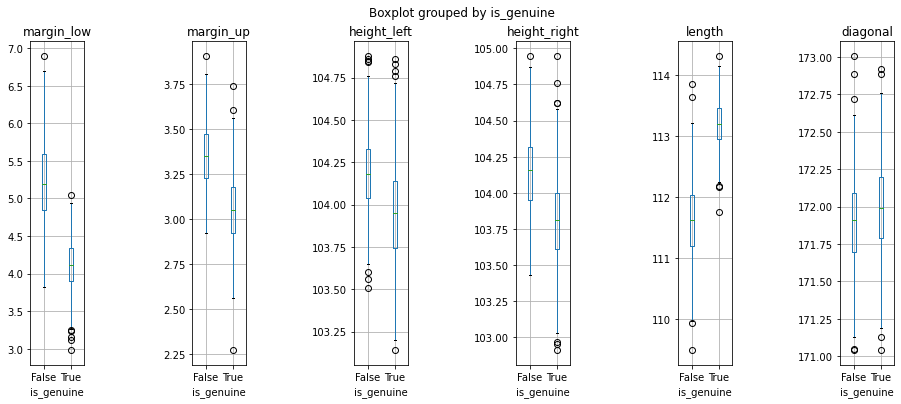

In [16]:
fig, ax = plt.subplots(1, 6, figsize=(15, 6))

# draw boxplots - for one column in each subplot
billet.boxplot('margin_low', by = 'is_genuine',  ax=ax[0])
billet.boxplot('margin_up', by = 'is_genuine', ax=ax[1])
billet.boxplot('height_left',by = 'is_genuine',  ax=ax[2])
billet.boxplot('height_right',by = 'is_genuine', ax=ax[3])
billet.boxplot('length',by = 'is_genuine', ax=ax[4])
billet.boxplot('diagonal',by = 'is_genuine', ax=ax[5])

plt.subplots_adjust(wspace=2) 

plt.show()

Les boxplots confirment l'analyse des distributions r√©alis√©e via les histogrammes : 

Les variables 'margin_low' et 'margin_up' ont des  m√©dianes significativement plus √©lev√©es pour les faux billets.

La variable 'length' a une m√©diane plus faible pour les faux billet. 

Les variables 'height_left' et 'height_righ' ont des m√©dianes l√©g√®rement plus √©lev√©es pour les faux billets.

La variable 'diagonal' n'est pas significative car tr√®s peu de diff√©rence entre la m√©diane des vrais et faux billets. 

<br>
<div class="alert alert-success">
<b>NOTE</b> 
    
Les faux billets ont une marge haute et une marge basse plus grande par rapport aux vrais billets.

Les faux billets sont moins longs que les vrais billets. 

## Matrice des corr√©lations

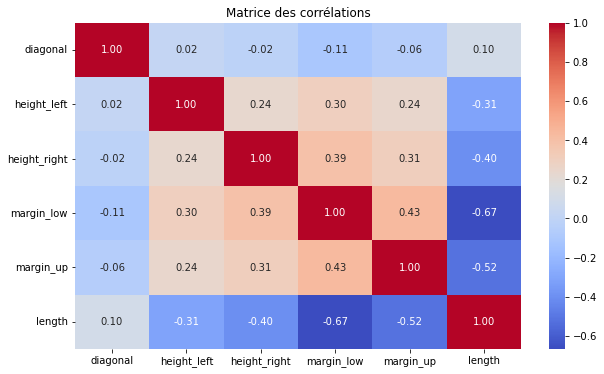

In [17]:
plt.figure(figsize=(10, 6))
sns.heatmap(billet.iloc[:, 1:].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Matrice des corr√©lations')
plt.show()

> Constat : 

- Forte corr√©lation entre margin_low et length (corr√©lation n√©gative)
- Moyenne corr√©lation entre margin_low et margin_up (corr√©lation positive)
- Forte corr√©lation entre margin_up et length (corr√©lation n√©gative)

## Pairplot

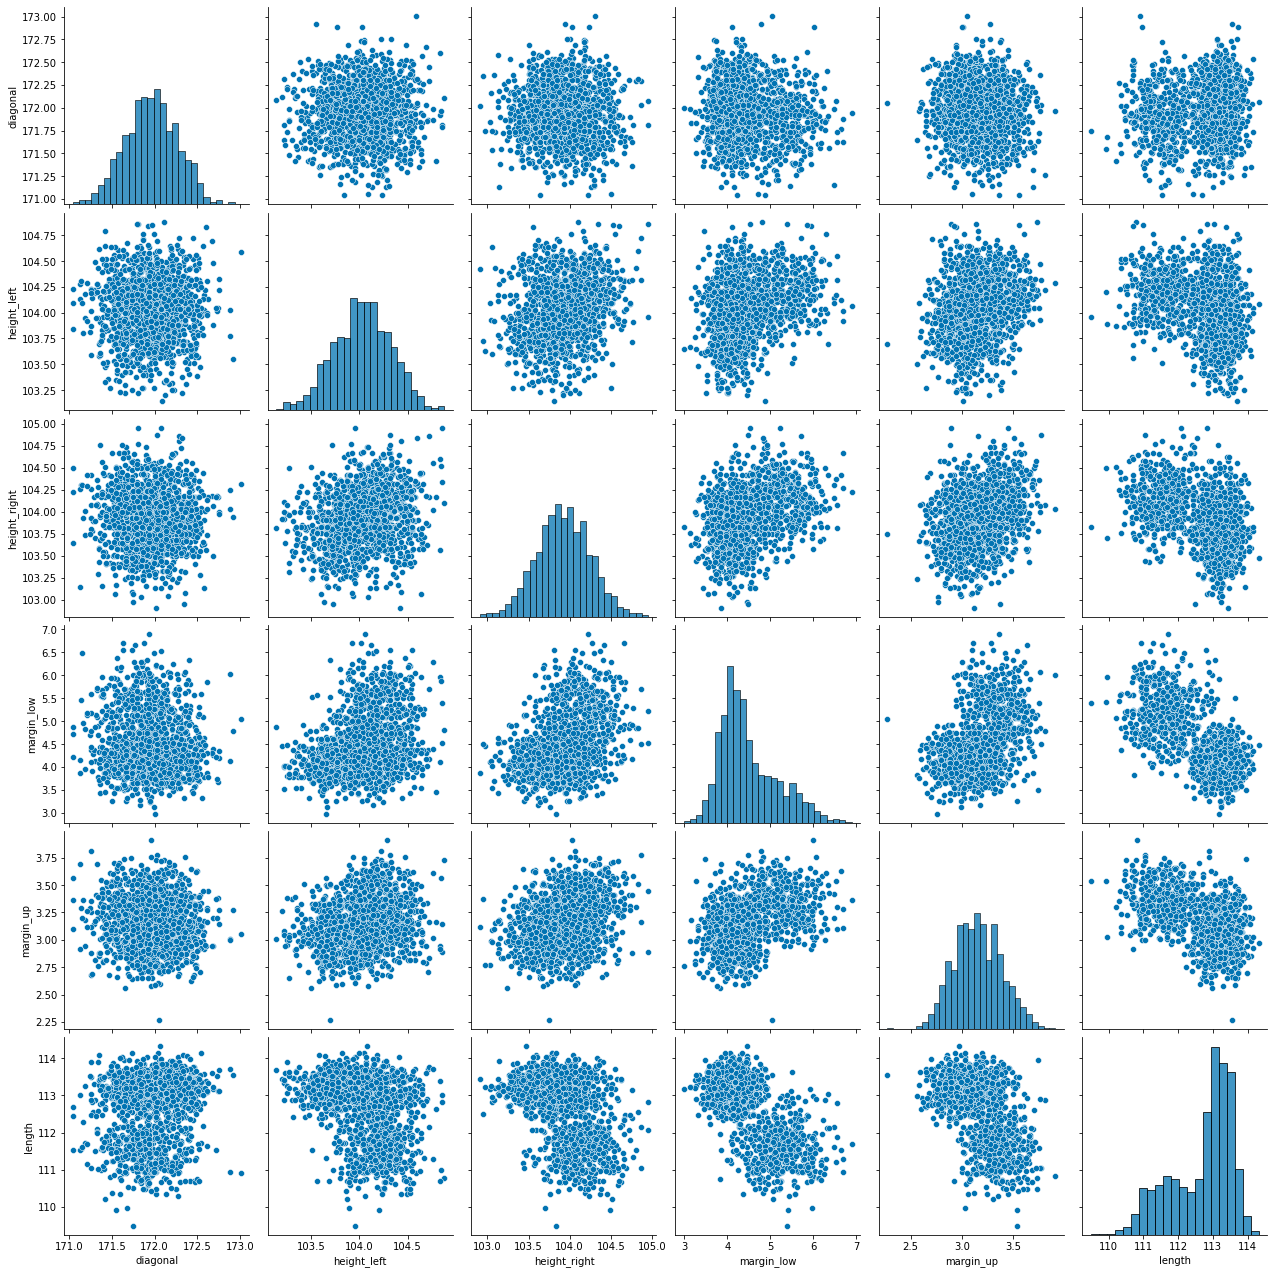

In [18]:
sns.set_palette('colorblind')
sns.pairplot(data=billet.drop('is_genuine', axis =1), height=3)

> Ce pairplot nous confirme les observations r√©alis√©es en amont : 
- les variables suivent une loi normale except√©e la variable length;
- margin_low et length sont corr√©le√©s n√©gativement (plus la variable 'length' sera √©lev√©e et plus la variable 'margin_low' va diminuer);
- margin_up et length sont corr√©l√©es n√©gativement √©galement;
- margin_low et margin_up sont corr√©le√©s positivement (elles √©voluent en m√™me temps).

<br> 
‚Äã
<div class="alert alert-info"><b>PREMIERES ANALYSES</b> 
    
1 - Le jeu de donn√©es contient 1500 valeurs : 1000 vrais billets et 500 faux billets

2 - Les variables de notre jeu de donn√©es correspondent aux dimensions g√©om√©triques des billets :
    
- la longueur du billet (en mm) ;
    
- la hauteur du billet (mesur√©e sur le c√¥t√© gauche, en mm) ;
    
- la hauteur du billet (mesur√©e sur le c√¥t√© droit, en mm) ;
    
- la marge entre le bord sup√©rieur du billet et l'image de celui-ci (en mm) ;
    
- la marge entre le bord sup√©rieur du billet et l'image de celui-ci (en mm) ;
    
- la marge entre le bord inf√©rieur du billet et l'image de celui-ci (en mm) ;
    
- la diagonale du billet (en mm).
    
3 - Apr√®s un premier tour d'horizon, nous pouvons contater que :
    
- le jeu de donn√©es suit une loi normale;
    
- 3 variables vont certainement permettre de diff√©rencier les vrais des faux billets ('margin_low', 'margin_up', 'length');
    
- une variable n'est pas significative dans la distinction des vrais et faux billets : 'diagonal';
    
- il manque 37 valeurs dans la colonne margin_low qu'il faut traiter.
‚Äã

## Visualisation de la variable √† pr√©dire (margin_low)

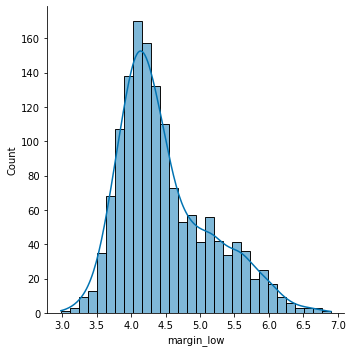

In [19]:
sns.displot(data=billet,x='margin_low', bins=30,kde=True);

> La distribution de la variable suit une loi normale (distribution Gaussienne)

<br> 
‚Äã
<div class="alert alert-danger"><b>Rappelons que la variable 'margin_low' est fortement corr√©l√©e avec la variable length (n√©gativement) et avec la variable 'margin_up' (positivement).</b>

## Corr√©lation de 'margin low' avec 'margin_up' et 'length'

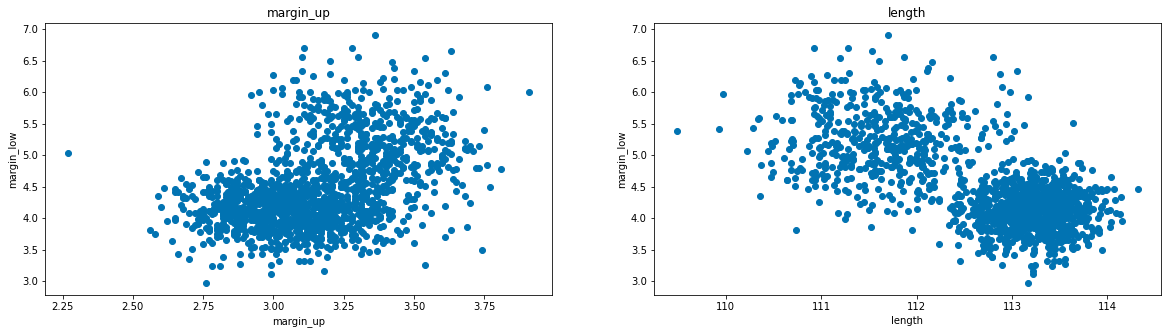

In [20]:
plt.figure(figsize=(20, 5))

features = ['margin_up', 'length']
target = billet['margin_low']

for i, col in enumerate(features):
    plt.subplot(1, len(features) , i+1)
    x = billet[col]
    y = target
    plt.scatter(x, y, marker='o')
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('margin_low')

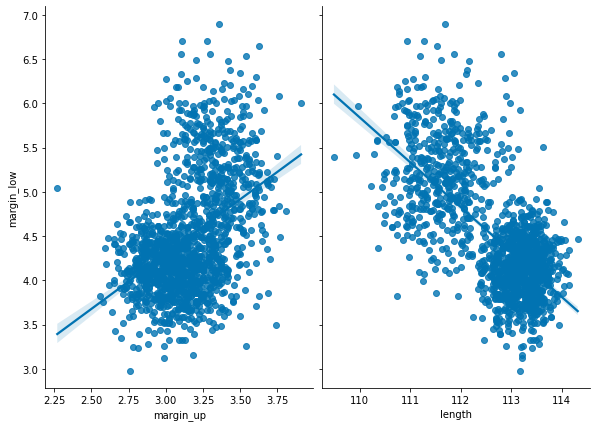

In [21]:
ax = sns.pairplot(billet, x_vars=['margin_up','length'], y_vars='margin_low', height= 6,aspect=0.7, kind='reg')
plt.show()

# Traitement des valeurs manquantes

**Objectif** : pr√©dire les valeurs manquantes dans la colonne margin_low.

**M√©thode** : R√©gression lin√©aire

## R√©gression lin√©aire multiple

In [22]:
# on remplace les valeurs True et False de la colonne is_genuine par [1,0]
df = billet.copy()
df['is_genuine'].replace([True, False], [1,0], inplace = True)
df_nan['is_genuine'].replace([True, False], [1,0], inplace = True)

df.head()

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0           1    171.81       104.86        104.95        4.52       2.89   
1           1    171.46       103.36        103.66        3.77       2.99   
2           1    172.69       104.48        103.50        4.40       2.94   
3           1    171.36       103.91        103.94        3.62       3.01   
4           1    171.73       104.28        103.46        4.04       3.48   

   length  
0  112.83  
1  113.09  
2  113.16  
3  113.51  
4  112.54

In [23]:
df_nan.head()

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
72            1    171.94       103.89        103.45         NaN       3.25   
99            1    171.93       104.07        104.18         NaN       3.14   
151           1    172.07       103.80        104.38         NaN       3.02   
197           1    171.45       103.66        103.80         NaN       3.62   
241           1    171.83       104.14        104.06         NaN       3.02   

     length  
72   112.79  
99   113.08  
151  112.93  
197  113.27  
241  112.36

In [24]:
# On utilise la commande lm pour r√©gresser margin_low en fonction des autres variables de l'√©chantillon

reg_multi = smf.ols('margin_low~is_genuine+diagonal+height_left+height_right+margin_up+length', data=df).fit()
print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     390.7
Date:                Sat, 10 Dec 2022   Prob (F-statistic):          4.75e-299
Time:                        18:39:10   Log-Likelihood:                -774.14
No. Observations:                1463   AIC:                             1562.
Df Residuals:                    1456   BIC:                             1599.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        2.8668      8.316      0.345   

<br>
<div class="alert alert-success">
<b>NOTE</b> 

On constate ici que certains param√®tres ne sont pas significativement diff√©rents de 0, car leur p-valeur n'est pas inf√©rieure √† 5 %, le niveau de test que nous souhaitons.
    
Le  ùëÖ2  vaut environ 0.617, et le  ùëÖ2  ajust√© est d'environ 0.615. 

## Retirer les variables non significatives - Proc√©dure descendante (Backward)

> Nous allons maintenant retirer les variables non significatives. Nous commen√ßons par la moins significative : length, elle a une p-valeur de 0.87.

In [25]:
reg_multi = smf.ols('margin_low~is_genuine+diagonal+height_left+height_right+margin_up', data=df).fit()
print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     469.2
Date:                Sat, 10 Dec 2022   Prob (F-statistic):          2.12e-300
Time:                        18:39:10   Log-Likelihood:                -774.15
No. Observations:                1463   AIC:                             1560.
Df Residuals:                    1457   BIC:                             1592.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        2.4247      7.873      0.308   

> Nous constatons que c'est maintenant diagonal, avec une p-valeur de 0.72, qui est la moins significative. Nous la supprimons.

In [26]:
reg_multi = smf.ols('margin_low~is_genuine+height_left+height_right+margin_up', data=df).fit()
print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     586.8
Date:                Sat, 10 Dec 2022   Prob (F-statistic):          8.76e-302
Time:                        18:39:10   Log-Likelihood:                -774.21
No. Observations:                1463   AIC:                             1558.
Df Residuals:                    1458   BIC:                             1585.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.3902      5.476      0.071   

> Nous constatons que c'est au tour de la variable height_right d'√™tre supprim√©e :  

In [27]:
reg_multi = smf.ols('margin_low~is_genuine+height_left+margin_up', data=df).fit()
print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     782.5
Date:                Sat, 10 Dec 2022   Prob (F-statistic):          3.63e-303
Time:                        18:39:10   Log-Likelihood:                -774.45
No. Observations:                1463   AIC:                             1557.
Df Residuals:                    1459   BIC:                             1578.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       2.9104      4.035      0.721      

> Et pour finir, nous retirons la variable height_left :

In [28]:
reg_multi = smf.ols('margin_low~is_genuine+margin_up', data=df).fit()
print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     1174.
Date:                Sat, 10 Dec 2022   Prob (F-statistic):          1.24e-304
Time:                        18:39:11   Log-Likelihood:                -774.73
No. Observations:                1463   AIC:                             1555.
Df Residuals:                    1460   BIC:                             1571.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.9263      0.198     30.003      0.0

<br>
<div class="alert alert-success">
<b>NOTE</b> 

On remarque qu'√† pr√©sent, tous les param√®tres sont significatifs. Quant au $R^{2}$, il vaut environ 0.617 et $R^{2}$ ajust√© vaut 0.616.

*On peut donc utiliser ce mod√®le √† des fins de pr√©vision !*

> On cr√©e la variable 'margin_low_pred', avec les valeurs pr√©dites obtenues via la regression lin√©aire multiple.


> On cr√©e la variable 'residus' qui est la diff√©rence entre les valeurs de 'margin_low' et margin_low_pred'.

In [29]:
df['margin_low_pred'] = round(reg_multi.predict({'is_genuine' : df['is_genuine'],
                              'margin_up' : df['margin_up']}),2)

df['residus'] = reg_multi.resid
df.head()

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0           1    171.81       104.86        104.95        4.52       2.89   
1           1    171.46       103.36        103.66        3.77       2.99   
2           1    172.69       104.48        103.50        4.40       2.94   
3           1    171.36       103.91        103.94        3.62       3.01   
4           1    171.73       104.28        103.46        4.04       3.48   

   length  margin_low_pred   residus  
0  112.83             4.15  0.369454  
1  113.09             4.13 -0.359352  
2  113.16             4.14  0.260051  
3  113.51             4.13 -0.505114  
4  112.54             4.03  0.014498

## V√©rification des hypoth√®ses de validit√© de la r√©gresion lin√©aire

### V√©rifier la colin√©arit√© des variables

<br>
<div class="alert alert-success">
<b>NOTE</b> 

VIF (Variance Inflation Factor) signifie Facteur d'Inflation de la Variance. 
    
Au cours de l'analyse de r√©gression, le VIF √©value si les facteurs sont corr√©l√©s les uns aux autres (multi-colin√©arit√©), ce qui pourrait influencer les autres facteurs et r√©duire la fiabilit√© du mod√®le.
    
Si un VIF est sup√©rieur √† 10, nous avons une multi-colin√©arit√© √©lev√©e : la variation semblera plus grande et le facteur appara√Ætra plus influent qu'il ne l'est. 
    
Si le VIF est plus proche de 1, alors le mod√®le est beaucoup plus robuste, car les facteurs ne sont pas influenc√©s par la corr√©lation avec d'autres facteurs.

In [30]:
variables = reg_multi.model.exog
[variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])]

[1.5938854494007753, 1.5938854494007746]

In [31]:
# Instanciation:
reg_li_col = smf.ols("margin_low ~ diagonal + height_left + height_right + margin_up + length + is_genuine", 
                   data = df)
# Calculs:
res_li_col = reg_li_col.fit()

variables = res_li_col.model.exog


for VIF in [variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])]:
    if VIF <= 10:
        print("VIF > 10 : Pas de probl√®me de colin√©arit√©")

VIF > 10 : Pas de probl√®me de colin√©arit√©
VIF > 10 : Pas de probl√®me de colin√©arit√©
VIF > 10 : Pas de probl√®me de colin√©arit√©
VIF > 10 : Pas de probl√®me de colin√©arit√©
VIF > 10 : Pas de probl√®me de colin√©arit√©
VIF > 10 : Pas de probl√®me de colin√©arit√©


In [32]:
variables = res_li_col.model.exog
VIF = [variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])]
pd.DataFrame(VIF, df.drop(['margin_low', 'margin_low_pred','residus'], axis=1).columns.tolist()).rename(columns={0:'VIF'})

VIF
is_genuine    1.028199
diagonal      1.173711
height_left   1.320836
height_right  1.596090
margin_up     3.613255
length        4.725732

> Ici, tous les coefficients sont inf√©rieurs √† 10, il n'y a donc pas de probl√®me de colin√©arit√©.

### Tester l'homosc√©dasticit√©

L'homosc√©dasticit√© est une caract√©ristique d'un mod√®le de r√©gression lin√©aire qui implique que la variance des erreurs est constante dans le temps.

Nous allons tester la constance de la variance des r√©sidus.

In [33]:
_, pval, __, f_pval = statsmodels.stats.diagnostic.het_breuschpagan(reg_multi.resid, variables)
print('p value test Breusch Pagan:', pval)

p value test Breusch Pagan: 3.7074833680067386e-33


La p-value ici est inf√©rieure √† 5%, on rejette l'hypoth√®se H0 : les variances ne sont pas constantes (homosc√©dastiques).

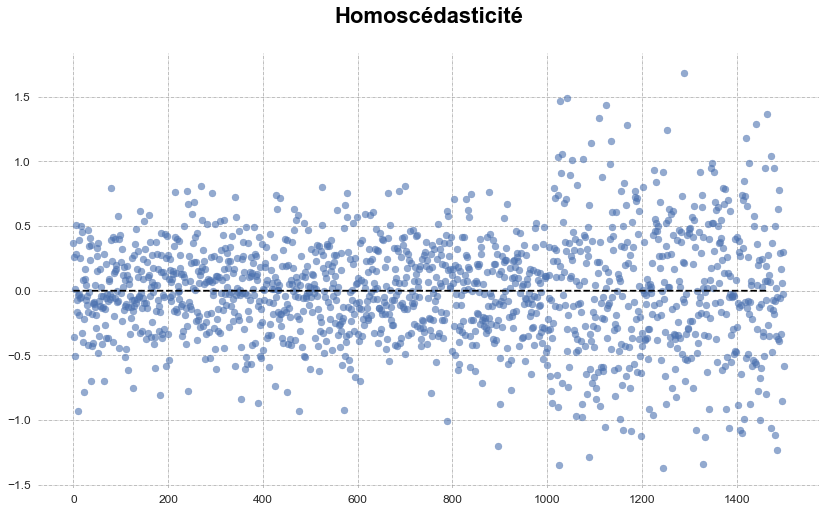

In [34]:
# Graphique:
plt.style.use('seaborn')
fig, ax = plt.subplots(figsize = (14,8))
ax.set_title("Homosc√©dasticit√©",
 fontsize=22, weight='bold', color='Black', loc='center',pad=30)
plt.box(False)
ax.yaxis.grid(linewidth=0.5,color='grey',linestyle='-.')
ax.xaxis.grid(linewidth=0.5,color='grey',linestyle='-.')
plt.scatter(x = df.index, y = df["residus"], alpha=0.6)
plt.plot(np.repeat(0, len(df.index)+2), color="black", linestyle='--')
plt.xticks(rotation=0, fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.show()

### Tester la normalit√© des r√©sidus

Si l'on veut tester la normalit√© des r√©sidus, on peut faire un test de Shapiro-Wilk.

**Rappel**

HO : Les r√©sidus suivent une loi normale

H1 : Les r√©sidus ne suivent pas une loi normale

In [35]:
stat, p = shapiro(reg_multi.resid)

print('Statistics=%.3f, p=%.12f' % (stat, p))

#Interpr√©tation
alpha = 0.05
if p > alpha:
    print('On ne peut pas rejeter H0 pour des niveaux de test de 5%')
else:
    print('H0 est rejet√©e pour des niveaux de test de 5%')

#shapiro(reg_multi.resid)

Statistics=0.994, p=0.000006209428
H0 est rejet√©e pour des niveaux de test de 5%


Ici, l'hypoth√®se de normalit√© est remise en cause (p-value < 0.05), on rejette HO, les r√©sidus ne suivent pas une loi normale. 



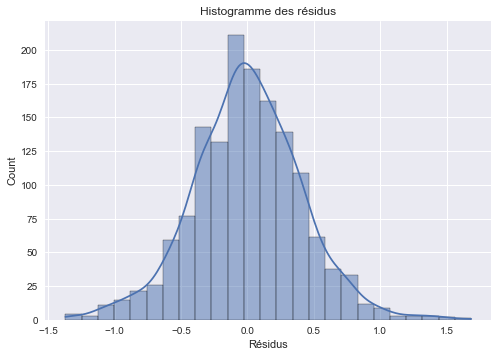

In [36]:
sns.histplot(reg_multi.resid, bins = 25, kde = True)
plt.xlabel('R√©sidus')
plt.title('Histogramme des r√©sidus');

<br>
<div class="alert alert-success">
<b>NOTE</b> 


Il est n√©cessaire de rappeler que m√™me si toutes les hypoth√®ses du mod√®le lin√©aire ne sont pas respect√©es, celui-ci √©tant robuste (surtout dans notre cas o√π la taille de l'√©chantilllon est sup√©rieure √† 30 individus), les r√©sultats du mod√®le lin√©aire restent valables. 

Nous avons d√©couvert que les r√©sidus ne sont ni gaussiens ni homosc√©dastiques mais l'application du mod√®le lin√©aire n'exige pas un respect exact des hypoth√®ses mais un respect approximatif ce qui est le cas dans ce projet. 

In [37]:
billet['is_genuine'].replace([True, False], [1,0], inplace = True)

In [38]:
billet_all['is_genuine'].replace([True, False], [1,0], inplace = True)

In [39]:
billet_all.loc[billet_all["margin_low"].isnull(), "margin_low"] = round(reg_multi.predict({'is_genuine' : billet_all['is_genuine'],
                              'margin_up' : billet_all['margin_up']}),2)

billet_all

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0              1    171.81       104.86        104.95        4.52       2.89   
1              1    171.46       103.36        103.66        3.77       2.99   
2              1    172.69       104.48        103.50        4.40       2.94   
3              1    171.36       103.91        103.94        3.62       3.01   
4              1    171.73       104.28        103.46        4.04       3.48   
...          ...       ...          ...           ...         ...        ...   
1495           0    171.75       104.38        104.17        4.42       3.09   
1496           0    172.19       104.63        104.44        5.27       3.37   
1497           0    171.80       104.01        104.12        5.51       3.36   
1498           0    172.06       104.28        104.06        5.17       3.46   
1499           0    171.47       104.15        103.82        4.63       3.37   

      length  
0     112.83  
1     113.09  
2     113.16  
3     113.51  
4     112.54  
...      ...  
1495  111.28  
1496  110.97  
1497  111.95  
1498  112.25  
1499  112.07  

[1500 rows x 7 columns]

In [40]:
billet_all.shape

(1500, 7)

In [41]:
billet_all.isnull().sum()

is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64

<br> 

<div class="alert alert-warning"><b>ON FAIT LE POINT</b> 

Nous avons r√©alis√© une premi√®re analyse exploratoire qui nous a permis de d√©couvrir quelles variables √©taient corr√©l√©es et √©taient susceptibles de nous permettre de distinguer les vrais des faux billets (margin_low, margin_up, length).

Nous avons r√©alis√© une r√©gression lin√©aire pour pr√©dire les donn√©es manquantes de la variable margin_low et nous les avons imput√©es.

Nous allons maintenant r√©aliser une Analyse en Composante Principale pour r√©duire nos variables et repr√©senter nos individus dans un espace √† deux dimensions.

# ACP

In [42]:
X = billet_all.copy()
X.set_index('is_genuine', inplace = True)

In [43]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


# Enregistrement des noms des billets (vrai ou faux) dans une variable 'names'
names = X.index

# Enregistrement des colonnes dans 'features'
features = X.columns

# On instancie
scaler = StandardScaler()

# On fit et on transforme
X_scaled = scaler.fit_transform(X)


# On esp√®re avoir une moyenne √† 0 et un √©cart type √† 1 : 

idx = ["mean", "std"]

pd.DataFrame(X_scaled).describe().round(2).loc[idx, :]

0    1    2    3    4    5
mean -0.0  0.0 -0.0 -0.0 -0.0  0.0
std   1.0  1.0  1.0  1.0  1.0  1.0

In [44]:
pd.DataFrame(X_scaled, index=X.index,columns=X.columns).head()

diagonal  height_left  height_right  margin_low  margin_up  \
is_genuine                                                               
1          -0.486540     2.774123      3.163240    0.056284  -1.128325   
1          -1.633729    -2.236535     -0.799668   -1.080708  -0.696799   
1           2.397823     1.504756     -1.291191   -0.125635  -0.912562   
1          -1.961498    -0.399294      0.060498   -1.308106  -0.610494   
1          -0.748754     0.836669     -1.414072   -0.671391   1.417677   

              length  
is_genuine            
1           0.173651  
1           0.471666  
1           0.551901  
1           0.953075  
1          -0.158750

In [45]:
# On instancie notre ACP
pca = PCA()

# On l'entraine sur les donn√©es scal√©es
pca.fit(X_scaled)

PCA()

In [46]:
pca.explained_variance_ratio_

array([0.43204615, 0.16957139, 0.130199  , 0.11825181, 0.09667101,
       0.05326065])

In [47]:
scree = (pca.explained_variance_ratio_*100).round(2)
scree

array([43.2 , 16.96, 13.02, 11.83,  9.67,  5.33])

In [48]:
scree_cum = scree.cumsum().round()
scree_cum

array([ 43.,  60.,  73.,  85.,  95., 100.])

In [49]:
x_list = range(6)
list(x_list)

[0, 1, 2, 3, 4, 5]

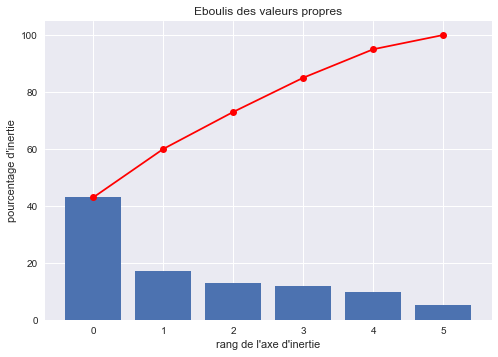

In [50]:
plt.bar(x_list, scree)
plt.plot(x_list, scree_cum,c="red",marker='o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)

In [51]:
n_components = 4
pca = PCA(n_components=n_components)
pca.fit(X_scaled)

PCA(n_components=4)

In [52]:
pcs = pca.components_
pcs = pd.DataFrame(pcs)
pcs

0         1         2         3         4         5
0 -0.084841  0.331337  0.393762  0.506580  0.439317 -0.527585
1  0.941306  0.307252  0.108598 -0.073165 -0.004426  0.048705
2 -0.287022  0.884790 -0.165738 -0.106968 -0.270951  0.149800
3 -0.102828 -0.047599  0.866850 -0.091397 -0.442679  0.177239

In [53]:
X_proj = pca.transform(X_scaled)
X_proj[:10]

array([[ 1.64721654e+00,  7.47227687e-01,  2.39560692e+00,
         3.18515800e+00],
       [-2.01974380e+00, -2.20673545e+00, -1.00235609e+00,
         7.20876568e-02],
       [-9.68997225e-01,  2.61931623e+00,  1.20053710e+00,
        -9.24182858e-01],
       [-1.37575329e+00, -1.81765506e+00,  6.47785185e-01,
         8.31877575e-01],
       [ 1.50386746e-01, -5.66189636e-01,  8.53465216e-01,
        -1.78297059e+00],
       [-6.95869595e-01,  4.27002394e-01, -8.67735411e-01,
         8.20289273e-01],
       [ 1.76197372e-01,  1.30270168e+00,  1.49074841e-03,
        -5.33808252e-01],
       [-1.15114509e+00, -3.82759583e-01, -3.83013344e-01,
         1.08797459e+00],
       [-8.54029515e-01,  1.44364402e+00, -6.85000068e-01,
        -9.08027334e-01],
       [-5.96747820e-01,  1.74342231e+00, -3.23330210e-01,
         1.16515903e-01]])

In [54]:
X_proj = pd.DataFrame(X_proj, columns = ["F1", "F2", "F3", "F4"])
X_proj[:10]

F1        F2        F3        F4
0  1.647217  0.747228  2.395607  3.185158
1 -2.019744 -2.206735 -1.002356  0.072088
2 -0.968997  2.619316  1.200537 -0.924183
3 -1.375753 -1.817655  0.647785  0.831878
4  0.150387 -0.566190  0.853465 -1.782971
5 -0.695870  0.427002 -0.867735  0.820289
6  0.176197  1.302702  0.001491 -0.533808
7 -1.151145 -0.382760 -0.383013  1.087975
8 -0.854030  1.443644 -0.685000 -0.908027
9 -0.596748  1.743422 -0.323330  0.116516

In [55]:
x_list = range(1, n_components+1)
list(x_list)

pcs.columns = features
pcs.index = [f"F{i}" for i in x_list]
pcs.round(2)

diagonal  height_left  height_right  margin_low  margin_up  length
F1     -0.08         0.33          0.39        0.51       0.44   -0.53
F2      0.94         0.31          0.11       -0.07      -0.00    0.05
F3     -0.29         0.88         -0.17       -0.11      -0.27    0.15
F4     -0.10        -0.05          0.87       -0.09      -0.44    0.18

In [56]:
x, y = 0,1

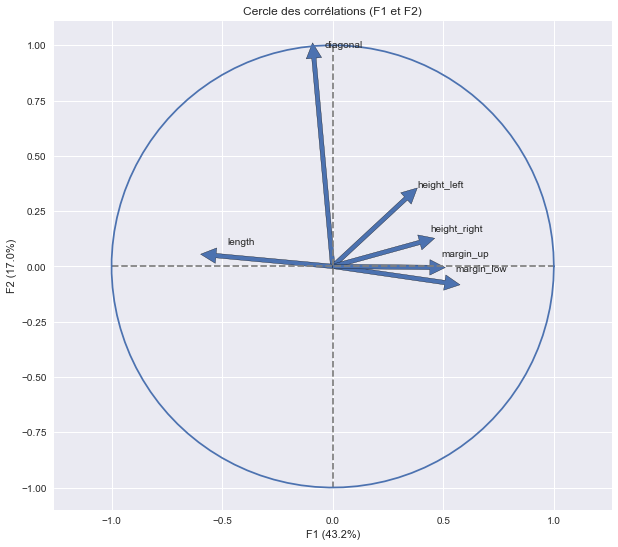

In [57]:
fig, ax = plt.subplots(figsize=(10, 9))
for i in range(0, pca.components_.shape[1]):
    ax.arrow(0,
             0,  # Start the arrow at the origin
             pca.components_[0, i],  #0 for PC1
             pca.components_[1, i],  #1 for PC2
             head_width=0.07,
             head_length=0.07, 
             width=0.02,              )

    plt.text(pca.components_[0, i] + 0.05,
             pca.components_[1, i] + 0.05,
             features[i])
    
# affichage des lignes horizontales et verticales
plt.plot([-1, 1], [0, 0], color='grey', ls='--')
plt.plot([0, 0], [-1, 1], color='grey', ls='--')


# nom des axes, avec le pourcentage d'inertie expliqu√©
plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

plt.title("Cercle des corr√©lations (F{} et F{})".format(x+1, y+1))


an = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale
plt.axis('equal')
plt.show(block=False)

<br>
<div class="alert alert-success">
<b>NOTE</b> 

Les variables les plus corr√©l√©es √† F1 sont margin_up et margin_low. 
    
Elles sont corr√©l√©es n√©gativement √† la variable length : au plus les valeurs de la variable length augmentent, au plus les valeurs des variables margin_low et margin_up diminuent. 
    
La variable height_right est √©galement corr√©l√©e √† F1 alors que height_left  n'est ni corr√©l√©e √† F1 et F2.
    
La variable diagonal est fortement corr√©l√©e √† F2 et, comme constat√© en amont,  elle n'est pas significative.
    

In [58]:
labels = billet_all.is_genuine 

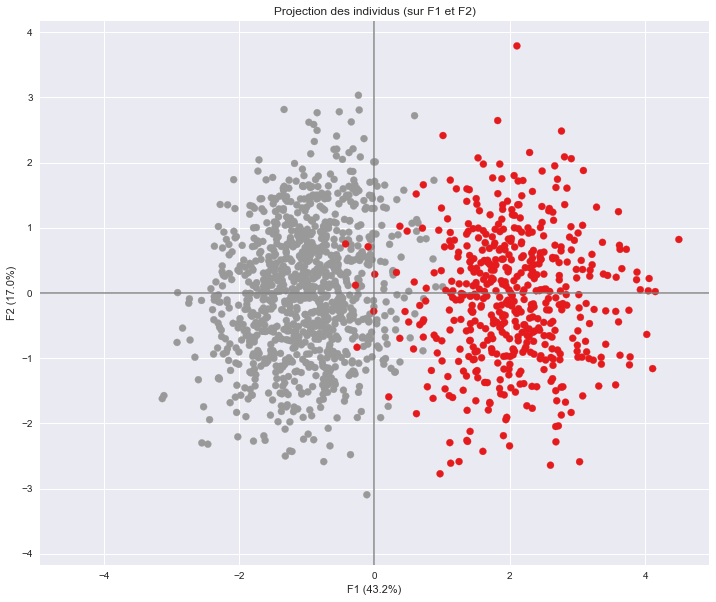

In [59]:
fig, ax = plt.subplots(1,1, figsize=(12,10))

#Transforme notre DataFrame d'origine
X_ = np.array(X_proj)

# On enregistre nos axes x, y
x, y = axis = (0,1 )

# plus besoin d'utiliser iloc
ax.scatter(X_[:, 0], X_[:, 1], c= labels, cmap="Set1")

# nom des axes, avec le pourcentage d'inertie expliqu√©
ax.set_xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
ax.set_ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

# valeur x max et y max
x_max = np.abs(X_[:, x]).max() *1.1
y_max = np.abs(X_[:, y]).max() *1.1

# affichage des lignes horizontales et verticales
plt.plot([-x_max, x_max], [0, 0], color='grey', alpha=0.8)
plt.plot([0,0], [-y_max, y_max], color='grey', alpha=0.8)

# on borne x et y 
ax.set_xlim(left= -x_max, right=x_max)
ax.set_ylim(bottom= -y_max, top=y_max)

# un titre
plt.title("Projection des individus (sur F{} et F{})".format(x+1, y+1) )
plt.show()

<br>
<div class="alert alert-success">
<b>NOTE</b> 

> Suite √† l'ACP et √† la projection des individus nous pouvons constater que les faux billets se trouvent en grande majorit√© du c√¥t√© des variables margin_low et margin_up alors que les vrais billets se trouvent √† gauche de notre projection, du c√¥t√© de la variable length. 

Ce sont les 3 variables qui montraient des diff√©rences importantes entre les vrais et faux billets. 


Les variables qui permettent d'expliquer les diff√©rences entre les vrais et les faux billets sont : 

- margin_low
- margin_up
- length

<br> 

<div class="alert alert-warning"><b>  <b>
    
Analysons les corr√©lations entre ces 3 variables. 

## Corr√©lation entre margin_low et margin_up (tous les billets)

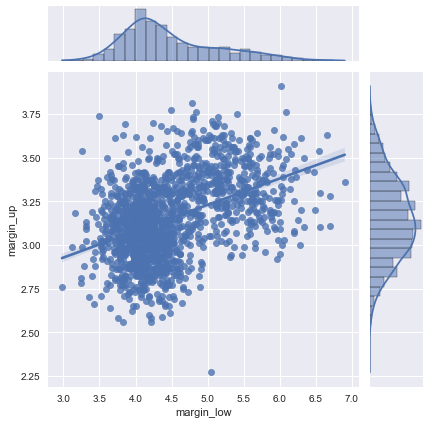

In [60]:
sns.jointplot(x = 'margin_low', y = 'margin_up', data = billet_all, kind = "reg");

> Ici on peut parler de **corr√©lation positive** : les points sont regroup√©s et partent du coin inf√©rieur gauche et se dirigent en haut √† droite.


> Les points sont rapproch√©s autour de la droite de r√©gression ce qui explique √©galement une forte corr√©lation. 

> Les distributions suivent une loi normale.

## Corr√©lation entre margin_low et margin_up (entre vrais et faux billets)

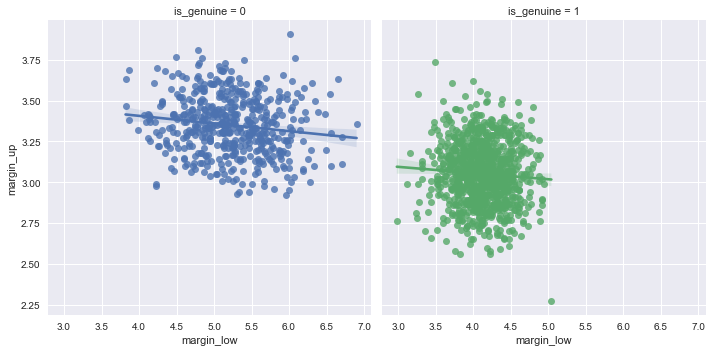

In [61]:
sns.lmplot(x = 'margin_low', y =  'margin_up',  col = 'is_genuine', hue = "is_genuine", data = billet_all);


> Nous pouvons constater que les variables margin_low et margin_up des vrais billets sont TRES corr√©l√©es contrairement aux faux billets qui ne le sont que moyennement (les individus sont √©parpill√©s).

## Corr√©lation entre margin_low et length (tous les billets)

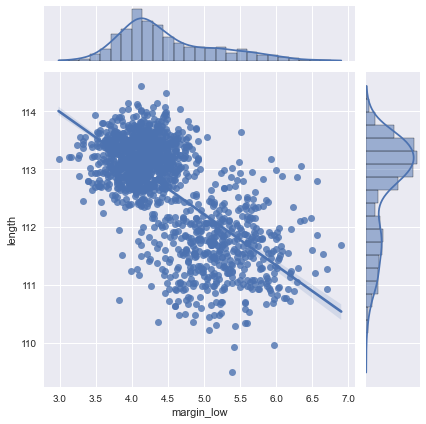

In [62]:
sns.jointplot(x = 'margin_low', y = 'length', data = billet_all, kind = "reg");

> Ce graphique nous confirme ce que nous avons pu d√©tecter pr√©cedemment lors de la r√©alisation de l'ACP et de la projection des individus √† savoir que les variables margin_low et length sont corr√©l√©es n√©gativement (quand l'une augmente, l'autre diminue). 

## Corr√©lation entre margin_low et length (entre vrais et faux billets)

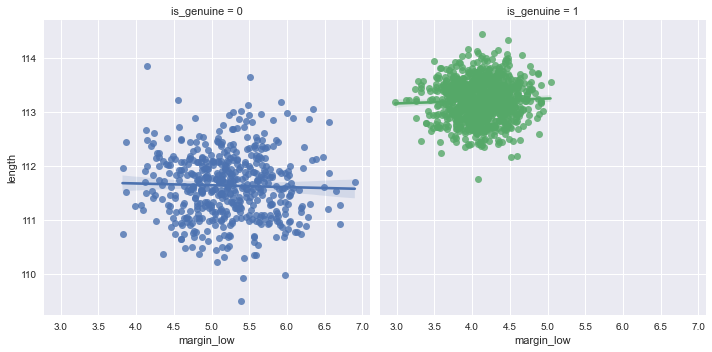

In [63]:
sns.lmplot(x = 'margin_low', y =  'length',  col = 'is_genuine', hue = "is_genuine", data = billet_all);

> M√™me constat que pour margin_low et margin_up, les variables des vrais billets sont tr√®s corr√©l√©es et resser√©es autour de la droite de r√©gression contrairement aux donn√©es des faux billets. 
    

## Corr√©lation entre margin_up et length

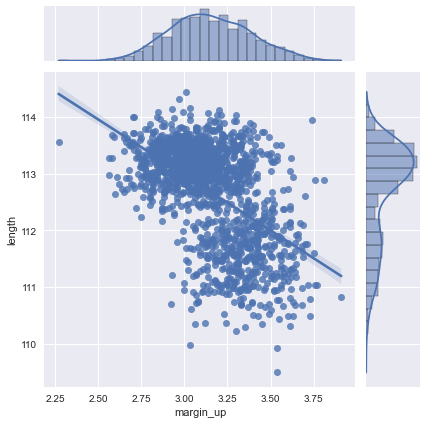

In [64]:
sns.jointplot(x = 'margin_up', y = 'length', data = billet_all, kind = "reg");

> Margin_up et et length ont une corr√©lation n√©gative : elles √©voluent en sens inverse.

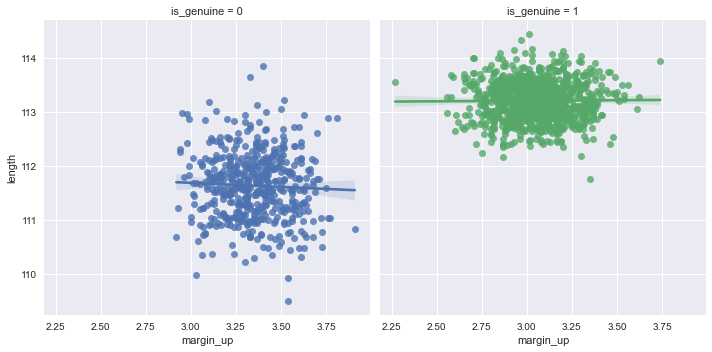

In [65]:
sns.lmplot(x = 'margin_up', y =  'length',  col = 'is_genuine', hue = "is_genuine", data = billet_all);

<br>
<div class="alert alert-success">
<b>NOTE</b> 
    
Les 3 variables corr√©l√©es (margin_low, margin_up et length) nous r√©velent la m√™me chose √† savoir que les valeurs des vrais billets sont fortement corr√©l√©es entre elles contrairement aux valeurs des faux billets.

# K-MEANS

<br> 

<div class="alert alert-warning">  

<b>OBJECTIF</b> 

Classer un ensemble de donn√©es dans un nombre de clusters, d√©fini par la lettre ¬´ k¬´ , qui est fix√© au pr√©alable.

<b>METHODE</b> 

- D√©termination de la valeur K (le nombre de clusters optimal) via la m√©thode du coude (Elbow method)
- Application de l‚Äôalgorithme de K Means
- Analyse des Clusters
</div>

## Nombre optimal de clusters

In [66]:
from sklearn.model_selection import train_test_split

In [67]:
X = billet_all.drop('is_genuine', axis= 1).copy()
y = billet_all.is_genuine.copy()

In [68]:
# on instancie

scaler = StandardScaler()

# On fit et on transforme
X_scaled = scaler.fit_transform(X)

### M√©thode du coude (Elbow Method)

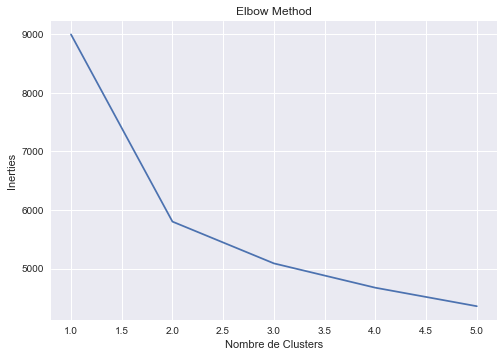

In [69]:
from sklearn.cluster import KMeans
wcss = []
mapping1 = {}
for i in range(1,6):
    km=KMeans(n_clusters=i)
    km.fit(X_scaled)
    wcss.append(km.inertia_)
    mapping1[i] = km.inertia_
plt.plot(range(1,6),wcss)
plt.title('Elbow Method')
plt.xlabel('Nombre de Clusters')
plt.ylabel('Inerties')
plt.show()


> Avec la m√©thode du coude nous pouvons d√©finir 2 clusters.

### M√©thode Silhouette score

In [70]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
range_n_clusters = list (range(2,10))
for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=1)
    preds = clusterer.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, preds)
    print("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))

For n_clusters = 2, silhouette score is 0.34346169166680707)
For n_clusters = 3, silhouette score is 0.20975545225191908)
For n_clusters = 4, silhouette score is 0.19702718598196164)
For n_clusters = 5, silhouette score is 0.15665439437091894)
For n_clusters = 6, silhouette score is 0.1492199662968838)
For n_clusters = 7, silhouette score is 0.1452815889126192)
For n_clusters = 8, silhouette score is 0.14590371575213512)
For n_clusters = 9, silhouette score is 0.13763307081855805)


> Avec la m√©thode du silhouette score, nous pouvons d√©finir que le nombre optimal de cluster est 2.

##  Clusters K-Means

In [71]:
kmeans = KMeans(n_clusters=2, random_state = 1) 
kmeans.fit(X_scaled)

KMeans(n_clusters=2, random_state=1)

In [104]:
cluster = pd.DataFrame({'cluster' : kmeans.labels_})
df_cluster = billet_all.join(cluster)
df_cluster

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0              1    171.81       104.86        104.95        4.52       2.89   
1              1    171.46       103.36        103.66        3.77       2.99   
2              1    172.69       104.48        103.50        4.40       2.94   
3              1    171.36       103.91        103.94        3.62       3.01   
4              1    171.73       104.28        103.46        4.04       3.48   
...          ...       ...          ...           ...         ...        ...   
1495           0    171.75       104.38        104.17        4.42       3.09   
1496           0    172.19       104.63        104.44        5.27       3.37   
1497           0    171.80       104.01        104.12        5.51       3.36   
1498           0    172.06       104.28        104.06        5.17       3.46   
1499           0    171.47       104.15        103.82        4.63       3.37   

      length  cluster  
0     112.83        0  
1     113.09        1  
2     113.16        1  
3     113.51        1  
4     112.54        1  
...      ...      ...  
1495  111.28        0  
1496  110.97        0  
1497  111.95        0  
1498  112.25        0  
1499  112.07        0  

[1500 rows x 8 columns]

## Visualisation des clusters 

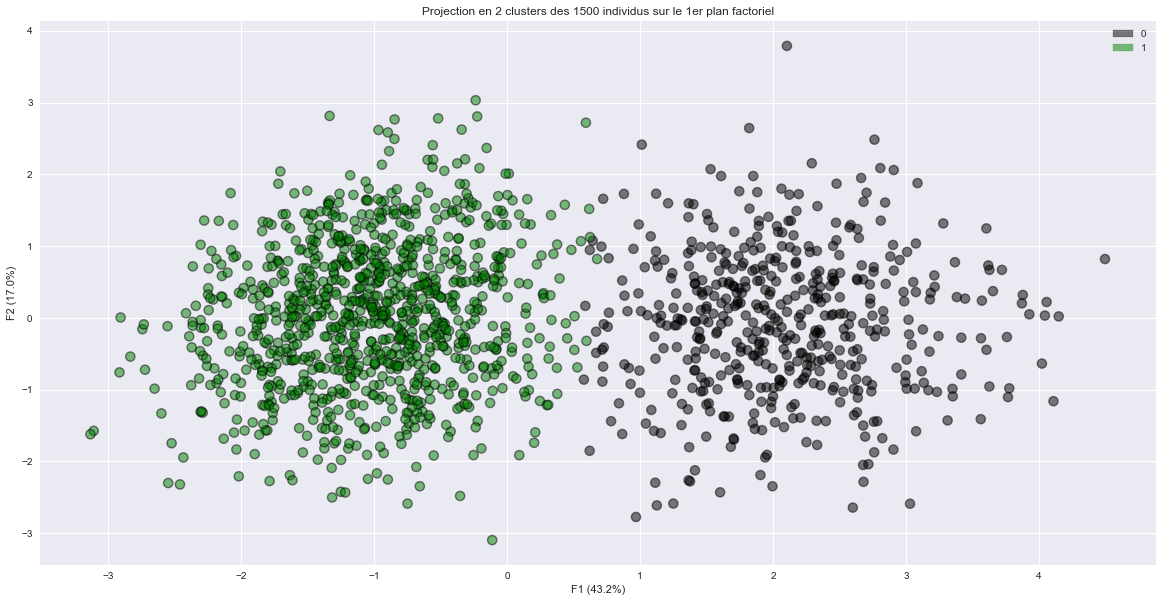

In [106]:
import matplotlib.patches as mpatches


#Coordonn√©es factorielles 
X_projected = pca.transform(X_scaled)
plt.figure(figsize=(20, 10))


colors = ['black', 'green']

plt.scatter(X_projected[:, 0], X_projected[:, 1], c=df_cluster['cluster'].apply(lambda x: colors[x]), 
            alpha=0.5, edgecolors='black', linewidths=1.4, s=85)



lab_0 = mpatches.Patch(color='black', alpha=0.5, label='0')
lab_1 = mpatches.Patch(color='green', alpha=0.5, label='1')


plt.legend(handles=[lab_0, lab_1])

plt.xlabel('F{} ({}%)'.format(1, round(100*pca.explained_variance_ratio_[0],1)))
plt.ylabel('F{} ({}%)'.format(2, round(100*pca.explained_variance_ratio_[1],1)))
plt.title("Projection en 2 clusters des {} individus sur le 1er plan factoriel".format(X_projected.shape[0]))

#plt.savefig("p6_graphic/projection_kmeans.png")
plt.show()

In [74]:
df_cluster['is_genuine'].replace([1,0], [True, False], inplace = True)

## Matrice de confusion

La matrice de confusion est un r√©sum√© des r√©sultats de pr√©diction pour un probl√®me particulier de classification. Elle compare les donn√©es r√©elles pour une variable cible √† celles pr√©dites par un mod√®le.

In [75]:
matrice = pd.crosstab(df_cluster['cluster'],df_cluster['is_genuine'],margins=True,margins_name = 'Total')
matrice_confusion =  pd.crosstab(df_cluster['cluster'],df_cluster['is_genuine'])
matrice
# cluster 0 = faux billets
# cluster 1 = vrais billets

is_genuine  False  True  Total
cluster                       
0             486    10    496
1              14   990   1004
Total         500  1000   1500

### Repr√©sentation graphique de la matrice de confusion

In [76]:
matrice_confusion

is_genuine  False  True
cluster                
0             486    10
1              14   990

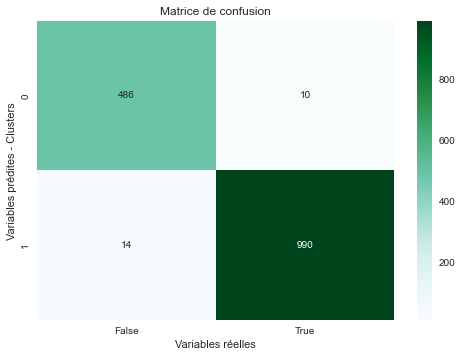

In [77]:
sns.heatmap(pd.DataFrame(matrice_confusion), annot=True, cmap="BuGn" ,fmt='g')

plt.title('Matrice de confusion')
plt.xlabel('Variables r√©elles')
plt.ylabel('Variables pr√©dites - Clusters')
plt.show()

> Selon la classification K-MEANS, le groupe 0 semble correspondre aux faux billets et le groupe 1 semble correspondre aux vrais billets.

> Parmi nos variables actuelles de faux billets, la m√©thode de classification K-MEANS d√©tecte 486 'vrais' faux billets et 14 'faux' vrais billets.

> Parmi nos variables actuelles de vrais billets, la m√©thode de classification K-MEANS d√©tecte 990 'vrais' vrais billets et 14 'faux' vrais billets. 

> 14 faux billets sont d√©tect√©s comme des vrais billets et 10 vrais billets sont d√©tect√©s comme des faux billets. 

### Report Classification

Lorsqu‚Äôil est question de classifications le choix des m√©triques utilis√©es pour √©valuer un mod√®le est primordial. 
Voici quelques unes des m√©triques :

**Pr√©cision** : c‚Äôest la m√©trique la plus simple, il s‚Äôagit simplement de la proportion de pr√©dictions correctes parmi toutes les pr√©dictions faites par le mod√®le.

**Recall** : le recall est initialement une m√©trique utilis√©e pour des classifications binaires correspond √† la proportion de pr√©dictions positive lorsqu‚Äôon s‚Äôattend √† ce que le r√©sultat soit positif.

**F1-Score** : le F1-Score est une combinaison des deux m√©triques pr√©c√©dente, il est souvent utilis√© dans les papiers de recherches pour comparer les performances entre deux classifieurs.


In [78]:
df_cluster_2 = df_cluster.copy()

df_cluster_2['is_genuine'].replace( [True, False],[1,0], inplace = True)

In [79]:
reel = df_cluster_2.is_genuine
prediction = kmeans.labels_

In [80]:
from sklearn.metrics import classification_report

print(classification_report(reel,prediction))


              precision    recall  f1-score   support

           0       0.98      0.97      0.98       500
           1       0.99      0.99      0.99      1000

    accuracy                           0.98      1500
   macro avg       0.98      0.98      0.98      1500
weighted avg       0.98      0.98      0.98      1500



> 98% de classifications correctes parmi les clasifications faites par le mod√®le pour le cluster 0 (faux billets).

> 99% de classifications correctes parmi les classifications faites par le mod√®le pour le cluster 1 (vrais billets).

Il est possible d‚Äô√©valuer la coh√©rence entre les groupes de d√©part et le partitionnement trouv√© par K-means en utilisant l‚Äôindice de Rand ajust√©. 

In [81]:
from sklearn.metrics.cluster import adjusted_rand_score

adjusted_rand_score(reel,prediction)

0.9361771423949447

In [82]:
print('La performance de classification de notre mod√®le est de', round(metrics.accuracy_score(reel, prediction)*100,2),'%.')

La performance de classification de notre mod√®le est de 98.4 %.


# R√©gression logistique

In [83]:
from sklearn.linear_model import LogisticRegression


# donn√©es entra√Ænements et donn√©es tests

X = billet_all.drop('is_genuine', axis =1).copy()
y = billet_all.is_genuine.copy()

In [84]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.20)

In [85]:
X_train.shape

(1200, 6)

In [86]:
X_test.shape

(300, 6)

## Pr√©dictions

In [87]:
reg_logistique = LogisticRegression(random_state = 1)
reg_logistique.fit(X_train, Y_train)

y_pred = reg_logistique.predict(X_test) 

## Matrice de confusion R√©gression logistique

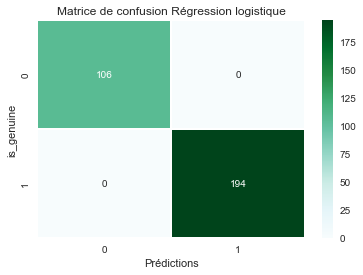

In [88]:
plt.figure(figsize=(6,4))
matrice_confusion_reg_log = pd.crosstab( Y_test, y_pred)
sns.heatmap(matrice_confusion_reg_log, annot = True, cmap="BuGn",fmt = ".3g", linewidths = 0.3)
plt.xlabel("Pr√©dictions")
plt.title("Matrice de confusion R√©gression logistique")
plt.show()


> Vrais positifs = 205 vrais billets sont d√©tect√©s comme vrais. 

> Vrais n√©gatifs = 93 faux billets sont d√©tect√©s comme faux. 

> Faux positif = 1 vrai billet est d√©tect√© comme faux.

> Faux n√©gatif = 1 faux billet est d√©tect√© comme vrai.

## Accuracy score (score de pr√©cision)

In [89]:
print(classification_report(Y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       106
           1       1.00      1.00      1.00       194

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



In [90]:
print('La performance de pr√©diction de notre mod√®le est de', round(metrics.accuracy_score(Y_test, y_pred)*100,2),'%.')

La performance de pr√©diction de notre mod√®le est de 100.0 %.


## Coefficient de d√©termination R2

Si R2=1: toute la variation est expliqu√©e par le mod√®le.

Si R2=0: aucune variation n'est expliqu√©e par le mod√®le.

In [91]:
# print('Train score: ',  round(reg_logistique.score(X_train,Y_train),2))
print('Test score: ',  round(reg_logistique.score(X_test,Y_test),2))

Test score:  1.0


In [92]:
from sklearn.metrics import precision_score, recall_score, accuracy_score

print("La performance de pr√©diction de notre mod√®le sur toutes les donn√©es tests est de  {}.".format(round(accuracy_score(Y_test, y_pred)), 4))
print("La pr√©cision de pr√©diction de notre mod√®le sur toutes les donn√©es tests est de  {}.".format(round(precision_score(Y_test, y_pred)), 4))
print("Le recall score de notre mod√®le sur toutes les donn√©es tests est de  {}.".format(round(recall_score(Y_test, y_pred)), 4))


La performance de pr√©diction de notre mod√®le sur toutes les donn√©es tests est de  1.
La pr√©cision de pr√©diction de notre mod√®le sur toutes les donn√©es tests est de  1.
Le recall score de notre mod√®le sur toutes les donn√©es tests est de  1.


## Courbe ROC

La courbe ROC est une mesure de la performance d‚Äôun classificateur binaire. On repr√©sente la mesure ROC sous la forme d'une courbe qui donne le taux de vrais positifs en fonction du taux de faux positifs.

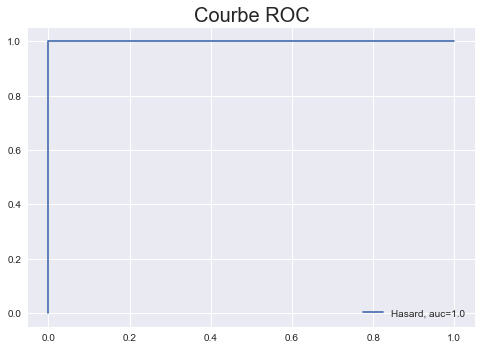

In [93]:
#ROC curve
y_pred_proba = reg_logistique.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(Y_test,  y_pred_proba)
auc = metrics.roc_auc_score(Y_test, y_pred_proba)
x = [0,1]
y = [0,1]
plt.plot(fpr,tpr,label="Hasard, auc="+str(auc))
plt.legend(loc=4)
plt.title('Courbe ROC', fontsize=20)
ax.set_ylabel('Taux Vraix Positifs', fontsize=14)
ax.set_xlabel('Taux Faux Positifs', fontsize=14)
plt.show()

In [94]:
print("AUC :",auc)


AUC : 1.0


AUC = 1 (Classificateur parfait, dans le meilleur des cas)

AUC = 0.5 (Classificateur inutile, dans le pire des cas)

Notre AUC = 0.9999

Comme avec les metrics calcul√©es plus haut, on retombe sur un mod√®le quasiment parfait avec une aire sous la courbe approxim√©e √† 1.

<br>
<div class="alert alert-success">
<b>CONCLUSION METHODES DE PREDICTIONS</b> 

Nous avons essay√© deux m√©thodes de pr√©diction : le K-MEANS et la r√©gression logistique.

Les deux m√©thodes nous donnent d'excellents r√©sultats.

La performance de pr√©diction de notre mod√®le K-MEANS est de 98.4 % et la performance de pr√©diction de notre mod√®le  avec la r√©gression logistique est de 99 %.

La performance de pr√©diction est sup√©rieurer avec la r√©gression logistique, nous utliiserons ce mod√®le pour identifier les vrais des faux billets.


## Application du mod√®le aux donn√©es tests (fichier 'billets_production)

In [95]:
# On importe le fichier √† tester
billets_prod = pd.read_csv(r'C:\Users\BDS CREATIONS\OneDrive\Bureau\OPEN CLASS ROOM\PROJETS OCR\PROJET 10\billets_production.csv')
billets_prod

diagonal  height_left  height_right  margin_low  margin_up  length   id
0    171.76       104.01        103.54        5.21       3.30  111.42  A_1
1    171.87       104.17        104.13        6.00       3.31  112.09  A_2
2    172.00       104.58        104.29        4.99       3.39  111.57  A_3
3    172.49       104.55        104.34        4.44       3.03  113.20  A_4
4    171.65       103.63        103.56        3.77       3.16  113.33  A_5

In [96]:
# On cr√©e un DF sans l'id
billets_prod_val = billets_prod.drop('id', axis = 1)
billets_prod_val

diagonal  height_left  height_right  margin_low  margin_up  length
0    171.76       104.01        103.54        5.21       3.30  111.42
1    171.87       104.17        104.13        6.00       3.31  112.09
2    172.00       104.58        104.29        4.99       3.39  111.57
3    172.49       104.55        104.34        4.44       3.03  113.20
4    171.65       103.63        103.56        3.77       3.16  113.33

In [97]:
# On identifie les vrais des faux billets avec le mod√®le de regression logistique et on affiche la probabilit√© 

pred_billets_prod = reg_logistique.predict(billets_prod_val)
proba_billets_prod = reg_logistique.predict_proba(billets_prod_val).round(3)[:, 1]
print(pred_billets_prod)
print(proba_billets_prod)

[0 0 0 1 1]
[0.005 0.001 0.001 0.911 1.   ]


In [98]:
# On ajoute la pr√©diction et la probabilit√© sur le fichier import√© 
billets_prod['Prediction'] = pred_billets_prod
billets_prod['Probabilit√©'] = proba_billets_prod
billets_prod['Prediction'].replace( [1,0],[True, False], inplace = True)
billets_prod

diagonal  height_left  height_right  margin_low  margin_up  length   id  \
0    171.76       104.01        103.54        5.21       3.30  111.42  A_1   
1    171.87       104.17        104.13        6.00       3.31  112.09  A_2   
2    172.00       104.58        104.29        4.99       3.39  111.57  A_3   
3    172.49       104.55        104.34        4.44       3.03  113.20  A_4   
4    171.65       103.63        103.56        3.77       3.16  113.33  A_5   

   Prediction  Probabilit√©  
0       False        0.005  
1       False        0.001  
2       False        0.001  
3        True        0.911  
4        True        1.000

In [99]:
# On cr√©e un df avec uniquement l'ID, la pr√©diction et la probabilit√©
df_prediction = billets_prod[['id', 'Prediction', 'Probabilit√©']].set_index("id")
df_prediction

Prediction  Probabilit√©
id                          
A_1       False        0.005
A_2       False        0.001
A_3       False        0.001
A_4        True        0.911
A_5        True        1.000

## D√©tection des faux billets avec une fonction 

In [110]:
def detection_billet(fichier):
    # on importe le fichier
    df_test = pd.read_csv(fichier)
   
    # on cr√©e un df sans id
    df_value = df_test.drop('id', axis=1)
    
    #Variable avec les pr√©dictions - Regression logistique
    pred = reg_logistique.predict(df_value)
    
    # Variable avec les probabilit√©s de la RL
    proba_pred = reg_logistique.predict_proba(df_value).round(3)[:, 1]
    
    # On ajoute √† notre DF test les donn√©es de pr√©dictions et de probabilit√©s
    df_test['Prediction'] = pred
    df_test['Prediction'].replace( [1,0],['Vrai', 'Faux'], inplace = True)
    
    df_test['Probabilit√©'] = proba_pred
    
    # On cr√©e un DF avec uniquement l'ID, les pr√©dictions et les probabilit√©s
    
    df_test_final = df_test[['id', 'Prediction', 'Probabilit√©']].set_index('id')
    #return df_test_final
    return df_test


In [111]:
detection_billet(r'C:\Users\BDS CREATIONS\OneDrive\Bureau\OPEN CLASS ROOM\PROJETS OCR\PROJET 10\billets_production.csv')

diagonal  height_left  height_right  margin_low  margin_up  length   id  \
0    171.76       104.01        103.54        5.21       3.30  111.42  A_1   
1    171.87       104.17        104.13        6.00       3.31  112.09  A_2   
2    172.00       104.58        104.29        4.99       3.39  111.57  A_3   
3    172.49       104.55        104.34        4.44       3.03  113.20  A_4   
4    171.65       103.63        103.56        3.77       3.16  113.33  A_5   

  Prediction  Probabilit√©  
0       Faux        0.005  
1       Faux        0.001  
2       Faux        0.001  
3       Vrai        0.911  
4       Vrai        1.000